# Force Oscillation

<!-- This notebook will show how to do a transient simulation with given scheduling results. -->

In [1]:
import andes

import matplotlib.pyplot as plt

In [2]:
!andes misc --version

Python  3.12.0
andes   1.9.3.post21.dev0+g37040896
numpy   2.2.5
kvxopt  1.3.2.1
sympy   1.14.0
scipy   1.13.1
pandas  2.2.3
numba   0.61.2


In [3]:
%matplotlib inline

In [4]:
andes.config_logger(stream_level=30)

Two-Area System [1]

More info can be found at:
<https://electricgrids.engr.tamu.edu/electric-grid-test-cases/two-area-system/>

1. Prabha Kundur. Power System Stability and Control. McGraw-Hill Professional, 1994.

In [5]:
case = andes.get_case('kundur/kundur_full.xlsx')

s1 = andes.load(case,
                setup=False, no_output=True, default_config=True,
                pert="./pert.py")
s2 = andes.load(case,
                setup=False, no_output=True, default_config=True,
                pert="./pert.py")
s3 = andes.load(case,
                setup=False, no_output=True, default_config=True,
                pert="./pert.py")

for ss in [s1, s2, s3]:
    ss.COI.add(idx='COI_1')
    ss.COI.add(idx='COI_2')

    # hard code COI to generators
    ss.GENROU.coi.v = ['COI_1'] * 2 + ['COI_2'] * 2

    # turn off the line trip
    ss.Toggle.set(src='u', attr='v', idx=1, value=0)

    ss.setup()

Generating code for 1 models on 12 processes.
Generating code for 1 models on 12 processes.
Generating code for 1 models on 12 processes.


In [6]:
# force oscilaltion config
t1, t2 = 1, 5
vd = 0.1

for ss, fd in zip([s1, s2, s3], [0.64, 0.32, 2.5]):
    ss.t1 = t1  # start time
    ss.t2 = t2  # end time
    ss.vd = vd  # disturbance magnitude
    ss.fd = fd  # disturbance frequency

In [7]:
for ss in [s1, s2, s3]:
    ss.TDS.config.tf = 50
    ss.TDS.config.no_tqdm = True
    ss.TDS.config.criteria = 0

    ss.PFlow.run()

    _ = ss.TDS.init()

    ss.exc = 2 # hard code exciter idx
    ss.vref0 = ss.EXDC2.get(src='vref0', attr='v', idx=ss.exc)

In [8]:
for ss, eig_name in zip([s1, s2, s3], ['case1', 'case2', 'case3']):
    ss.EIG.run()
    ss.files.eig = f'{eig_name}_eig.txt'
    ss.EIG.report()

In [9]:
for ss in [s1, s2, s3]:
    ss.TDS.run()

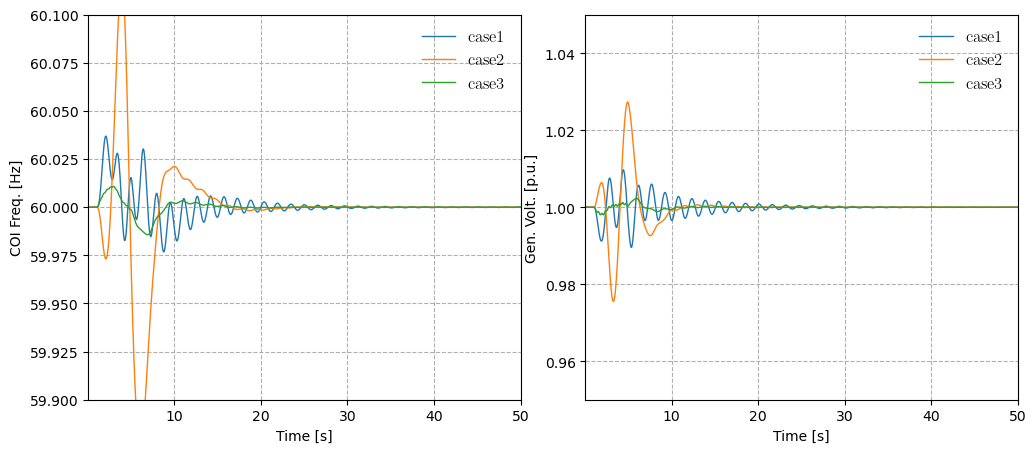

In [10]:
plt.style.use(['default'])
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(hspace=0.2, wspace=0.15)

vmin, vmax = 0.95, 1.05
fmin, fmax = 59.9, 60.1
vline = None # [10, 10.5]
_ = s1.TDS.plt.plot(s1.COI.omega,
                    a=(0),
                    ytimes=s1.config.freq,
                    grid=True, show=False,
                    vline=vline,
                    ymin=fmin, ymax=fmax,
                    fig=fig, ax=ax[0],
                    yheader=['case1'],
                    ylabel='COI Freq. [Hz]')
_ = s2.TDS.plt.plot(s2.COI.omega,
                    a=(0),
                    ytimes=s2.config.freq,
                    show=False,
                    fig=fig, ax=ax[0],
                    yheader=['case2'],
                    ylabel='COI Freq. [Hz]')
_ = s3.TDS.plt.plot(s3.COI.omega,
                    a=(0),
                    ytimes=s3.config.freq,
                    show=False,
                    fig=fig, ax=ax[0],
                    yheader=['case3'],
                    ylabel='COI Freq. [Hz]')

_ = s1.TDS.plt.plot(s1.GENROU.v,
                    a=(0),
                    grid=True, show=False,
                    vline=vline,
                    ymin=vmin, ymax=vmax,
                    fig=fig, ax=ax[1],
                    yheader=['case1'],
                    ylabel='Gen. Volt. [p.u.]')
_ = s2.TDS.plt.plot(s2.GENROU.v,
                    a=(0),
                    grid=True, show=False,
                    vline=vline,
                    ymin=vmin, ymax=vmax,
                    fig=fig, ax=ax[1],
                    yheader=['case2'],
                    ylabel='Gen. Volt. [p.u.]')
_ = s3.TDS.plt.plot(s3.GENROU.v,
                    a=(0),
                    grid=True, show=False,
                    vline=vline,
                    ymin=vmin, ymax=vmax,
                    fig=fig, ax=ax[1],
                    yheader=['case3'],
                    ylabel='Gen. Volt. [p.u.]')